In [1]:
import requests
import pyvo as vo
import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GD1Koposov10, GD1, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

In [14]:
name='GAIA@AIP'
url='https://gaia.aip.de/tap'
token = '7ce80ac34193bac1224ada67fbb5f057fd8fa00d'
tap_session = requests.Session()
tap_session.headers['Authorization'] = token
tap_service = vo.dal.TAPService(url, session=tap_session)

### Exercise:
If we used VizieR yesterday note: We are using a different Partner data site. Use the commands we learned at the beginning of yesterday to look at the tables available and identify the Gaia DR2 source table name and view the column names and units of this table. It might be useful to use the `table.show_in_notebook()` command to view your table in a searchable way

In [15]:
#Solution
table_query = "SELECT table_name from tap_schema.tables"
table_result = tap_service.run_sync(table_query)
table_table = table_result.to_table()
table_table.show_in_notebook()

idx,table_name
0,gaiaedr3_contrib.source_id2split
1,gaiaedr3_contrib.gaia_source_j2000
2,gaiaedr3_contrib.starhorse
3,gaiaedr3.skymapperdr2_join
4,gaiaedr3.urat1_best_neighbour
5,gaiaedr3.urat1_neighbourhood
6,gaiaedr3.allwise_best_neighbour
7,gaiaedr3.allwise_neighbourhood
8,gaiaedr3.apassdr9_best_neighbour
9,gaiaedr3.apassdr9_neighbourhood


In [16]:
#Solution
column_query = "select column_name, description, unit from tap_schema.columns where table_name = 'gaiadr2.gaia_source'"
column_table = tap_service.run_sync(column_query)
column_table.to_table()

column_name,description,unit
str256,str256,str256
solution_id,Solution Identifier,
designation,Unique source designation (unique across all Data Releases),
source_id,Unique source identifier (unique within a particular Data Release),
random_index,Random index used to select subsets,
ref_epoch,Reference epoch,Time[Julian Years]
ra,Right ascension,Angle[deg]
ra_error,Standard error of right ascension,Angle[mas]
dec,Declination,Angle[deg]
dec_error,Standard error of declination,Angle[mas]


Note that the unit column contains a description of the quantity in addition to the units - we will have to fix this later

In [2]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

In [4]:
len(selected_df)

1049

In [31]:
## May 8 download
candidate_df = pd.read_hdf('backup-data/gd1_data.hdf', 'candidate_df')

In [32]:
candidate_df.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec',
       'best_neighbour_multiplicity', 'number_of_mates', 'phi1', 'phi2',
       'pm_phi1', 'pm_phi2'],
      dtype='object')

In [33]:
len(candidate_df)

10

In [34]:
## May 9 download
candidate_df = pd.read_hdf('C:/Users/jahughes/Downloads/student_download(1)/student_download/backup-data/gd1_data.hdf', 'candidate_df')

In [35]:
len(candidate_df)

4300

In [36]:
candidate_df.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec',
       'best_neighbour_multiplicity', 'number_of_mates', 'g_mean_psf_mag',
       'i_mean_psf_mag', 'phi1', 'phi2', 'pm_phi1', 'pm_phi2'],
      dtype='object')

In [19]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

# Episode 5: Transform and Select

## Selection by proper motion

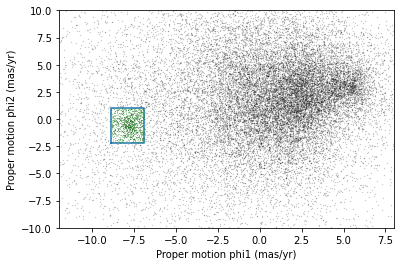

In [20]:
plot_proper_motion(centerline_df)

plt.plot(pm1_rect, pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3);

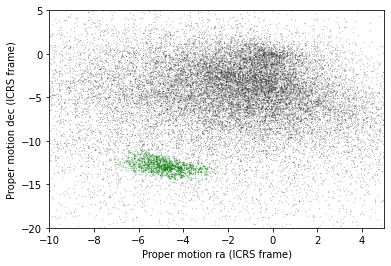

In [21]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)
    
plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

### Exercise:

Looking at the proper motion of the stars we identified along the centerline of GD-1, in the ICRS reference frame define a rectangle (pmra_min, pmra_max, pmdec_min, and pmdec_max) that encompass the proper motion of the majority of the stars near the centerline of GD-1 without including to much contamination from other stars.

In [22]:
pmra_min = -6.70
pmra_max = -3
pmdec_min = -14.31
pmdec_max = -11.2

## Assemble the query

In [23]:
candidate_coord_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT('ICRS', ra, dec), 
                   POLYGON('ICRS', {sky_point_list}))
"""

In [24]:
phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

In [25]:
phi1_rect, phi2_rect = make_rectangle(
    phi1_min, phi1_max, phi2_min, phi2_max)

In [26]:
corners = SkyCoord(phi1=phi1_rect, 
                   phi2=phi2_rect, 
                   frame=gd1_frame)

corners_icrs = corners.transform_to('icrs')

In [27]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

In [28]:
columns = 'source_id, ra, dec, pmra, pmdec'


In [29]:
candidate_coord_query = candidate_coord_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list)
print(candidate_coord_query)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT('ICRS', ra, dec), 
                   POLYGON('ICRS', 135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



## Selecting Proper Motion

### Exercise

Define candidate_coord_pm_query_base, starting with candidate_coord_query_base and adding two new BETWEEN clauses to select stars whose coordinates of proper motion, pmra and pmdec, fall within the region defined by pmra_min, pmra_max, pmdec_min, and pmdec_max. In the next exercise we will use the format statement to fill in the values we defined above.

In [30]:
candidate_coord_pm_query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT('ICRS', ra, dec), 
                   POLYGON('ICRS', {sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

### Exercise

Use format to format candidate_coord_pm_query_base and define candidate_coord_pm_query, filling in the values of columns, sky_point_list, and pmra_min, pmra_max, pmdec_min, pmdec_max.

In [31]:
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list,
                            pmra_min=pmra_min,
                            pmra_max=pmra_max,
                            pmdec_min=pmdec_min,
                            pmdec_max=pmdec_max)
print(candidate_coord_pm_query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT('ICRS', ra, dec), 
                   POLYGON('ICRS', 135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -6.7 AND -3
  AND pmdec BETWEEN -14.31 AND -11.2



In [32]:
candidate_coord_pm_job = tap_service.run_async(candidate_coord_pm_query)
candidate_coord_pm_job.infos

{'QUERY_STATUS': 'OK',
 'QUERY': "SELECT \nsource_id, ra, dec, pmra, pmdec\nFROM gaiadr2.gaia_source\nWHERE parallax < 1\n  AND bp_rp BETWEEN -0.75 AND 2 \n  AND 1 = CONTAINS(POINT('ICRS', ra, dec), \n                   POLYGON('ICRS', 135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))\n  AND pmra BETWEEN -6.7 AND -3\n  AND pmdec BETWEEN -14.31 AND -11.2",
 'QUERY_LANGUAGE': 'adql-2.0',
 'SOURCE': 'gaiadr2.gaia_source'}

In [33]:
candidate_gaia_table = candidate_coord_pm_job.to_table()
candidate_gaia_table

source_id,ra,dec,pmra,pmdec
,Angle[deg],Angle[deg],Angular Velocity[mas/year],Angular Velocity[mas/year]
int64,float64,float64,float64,float64
684751240206357376,136.07553479476417,20.858641590222035,-6.2541465876382505,-13.553910443109421
684614969484217472,135.28016823868472,20.306664668635438,-4.028998393801843,-11.219809837537092
684662626441347328,135.1453784776957,20.330503615090926,-5.467897791172192,-12.826169997419353
684655586991056512,135.15238351660247,20.24850361286202,-3.5020415298392957,-11.585200755131742
684682525024594816,135.06212986865035,20.576247265363623,-4.9266137358470345,-11.232616892125534
684631840115621888,134.70061126129164,20.090535408044154,-4.257745508479938,-11.524211235291316
684756943925532288,136.05763246574585,20.981390891959464,-3.9026173459697002,-12.263470466092858
684730177689339136,136.05482837612442,20.64696750059155,-4.937569905261754,-11.731101145837847


In [34]:
d = dict(sky_point_list=sky_point_list, pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, pmdec_max=pmdec_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

In [35]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

In [36]:
filename = 'gd1_data.hdf'
point_series.to_hdf(filename, 'point_series')

C:\Users\jahughes\AppData\Local\Temp\ipykernel_10376\1683950938.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(filename, 'point_series')


## Plotting one more time

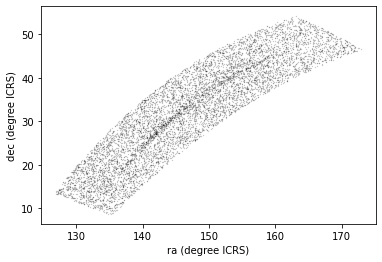

In [37]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

In [38]:
def rename_units(table):
    table['ra'].unit = u.deg
    table['dec'].unit = u.deg
    table['pmra'].unit = u.mas/u.year
    table['pmdec'].unit = u.mas/u.year
    return table

In [39]:
candidate_gaia_table = rename_units(candidate_gaia_table)
candidate_gaia_df = make_dataframe(candidate_gaia_table)

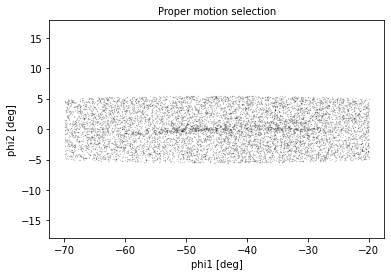

In [40]:
plot_pm_selection(candidate_gaia_df)